**Problem Statement:** the creation of a CNN-based melanoma detection model. If melanoma is not found in its early stages, it can be fatal. It is responsible for 75% of skin cancer fatalities. A model that can analyse photos and notify doctors of the existence of melanoma might potentially eliminate the need for a lot of manual diagnosis work.

Importing of required libraries

In [3]:
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import PIL
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython.display import display # Allows the use of display() for DataFrames
from time import time
import seaborn as sns # Plotting library
from keras.preprocessing import image
from keras.utils import np_utils
from sklearn.datasets import load_files   
from tqdm import tqdm
from collections import Counter

In [6]:
# mounting of the google drive
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
# unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip">/dev/null

**Importing Data**

The dataset used for this project contains roughly 2357 photos of various skin cancers. Each of the train and test subdirectories in the dataset has 9 subdirectories. The photos of the nine different forms of skin cancer are divided throughout the nine subdirectories.

In [8]:
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [9]:
# Count how many images there are in the Train and Test Directory.
# Using the glob to retrieve files/pathnames macthing the specified pattern.

# Train image counting
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

# Test image counting
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing library**
Let's use the useful image_dataset_from_directory tool to load these images from disc.

Create a dataset
Defining of some variables for the loader as instructed in problem statement:

In [11]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [12]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [13]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [14]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

The code to display a single instance of each of the dataset's nine classes can be found below.

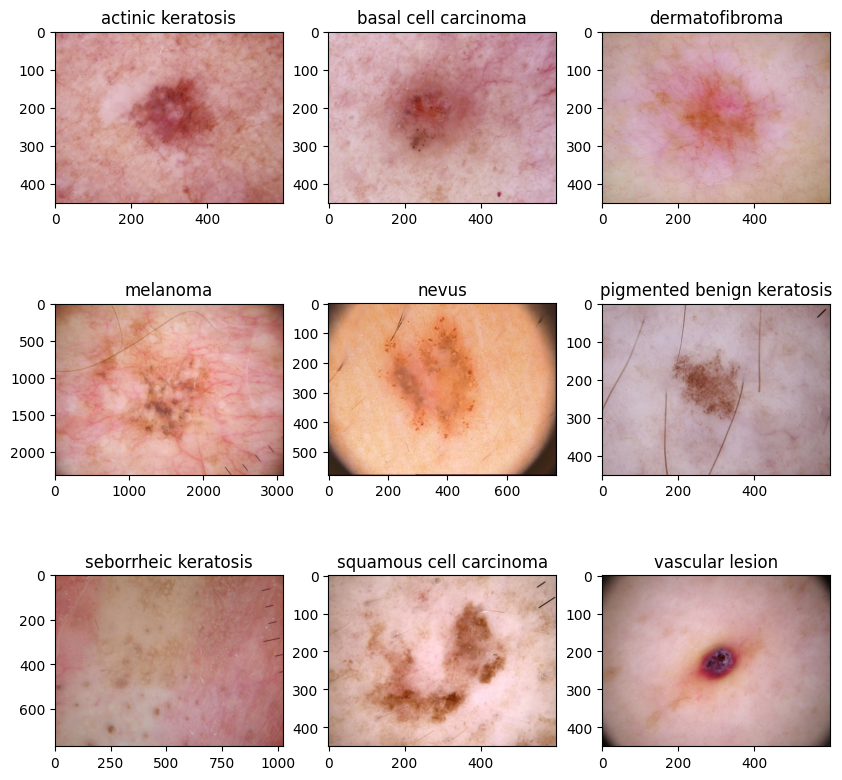

In [15]:
import matplotlib.image as mpimg
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The shape of the image_batch is (32, 180, 180, 3). This collection of 32 photos has the dimensions 180x180x3; the third dimension denotes the RGB colour channels. The labels for the 32 photos are contained in the tensor of shape (32,) known as the label_batch.

As soon as the photos are loaded from disc during the first epoch, Dataset.cache() maintains them in memory.

Dataset.Prefetch() combines model running and data preprocessing during training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create the model

The first base model that we developed is shown below:

In [17]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

**Compile the model**



Select the proper optimiser and loss function for the training of your model.

In [18]:
from tensorflow.keras.optimizers import RMSprop

We use SparseCategoricalCrossEntropy as the loss function because it is a multi-class classification, and Adam optimizer as a hit-and-trial method. In addition, we may perform hyper parameter optimisation and alter the optimizer accordingly.



In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

Train the model

In [22]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 35s 166ms/step - loss: 2.0588 - accuracy: 0.1791 - val_loss: 2.0220 - val_accuracy: 0.1924
Epoch 2/30
56/56 [==============================] - 5s 88ms/step - loss: 2.0215 - accuracy: 0.1908 - val_loss: 2.0297 - val_accuracy: 0.2058
Epoch 3/30
56/56 [==============================] - 5s 88ms/step - loss: 2.0281 - accuracy: 0.1942 - val_loss: 2.0193 - val_accuracy: 0.1991
Epoch 4/30
56/56 [==============================] - 5s 86ms/step - loss: 1.9704 - accuracy: 0.2450 - val_loss: 1.9379 - val_accuracy: 0.2550
Epoch 5/30
56/56 [==============================] - 5s 86ms/step - loss: 1.8939 - accuracy: 0.3013 - val_loss: 1.7795 - val_accuracy: 0.3826
Epoch 6/30
56/56 [==============================] - 5s 86ms/step - loss: 1.8916 - accuracy: 0.3019 - val_loss: 1.9591 - val_accuracy: 0.2550
Epoch 7/30
56/56 [==============================] - 5s 85ms/step - loss: 1.8206 - accuracy: 0.3359 - val_loss: 1.8262 - val_accuracy: 0.3579
Epoch 8/30
56/56 [====

Visualize the training results

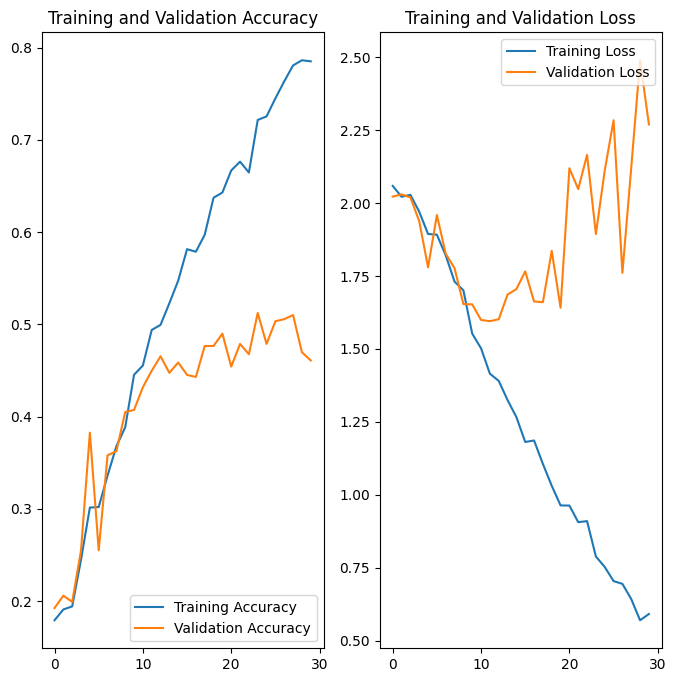

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings on the first base model
Initial findings: Because overfitting is calculated relative to loss, the model is overfitting, and we can also notice differences between training and test loss functions around the 19–20th epoch. Due to the neural network's young (only 20 epochs) and the fact that there are enough features to recall the pattern, the accuracy is only about 50–60%. However, it's still too early to weigh in on the overfitting vs. underfitting controversy.

In [24]:
data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

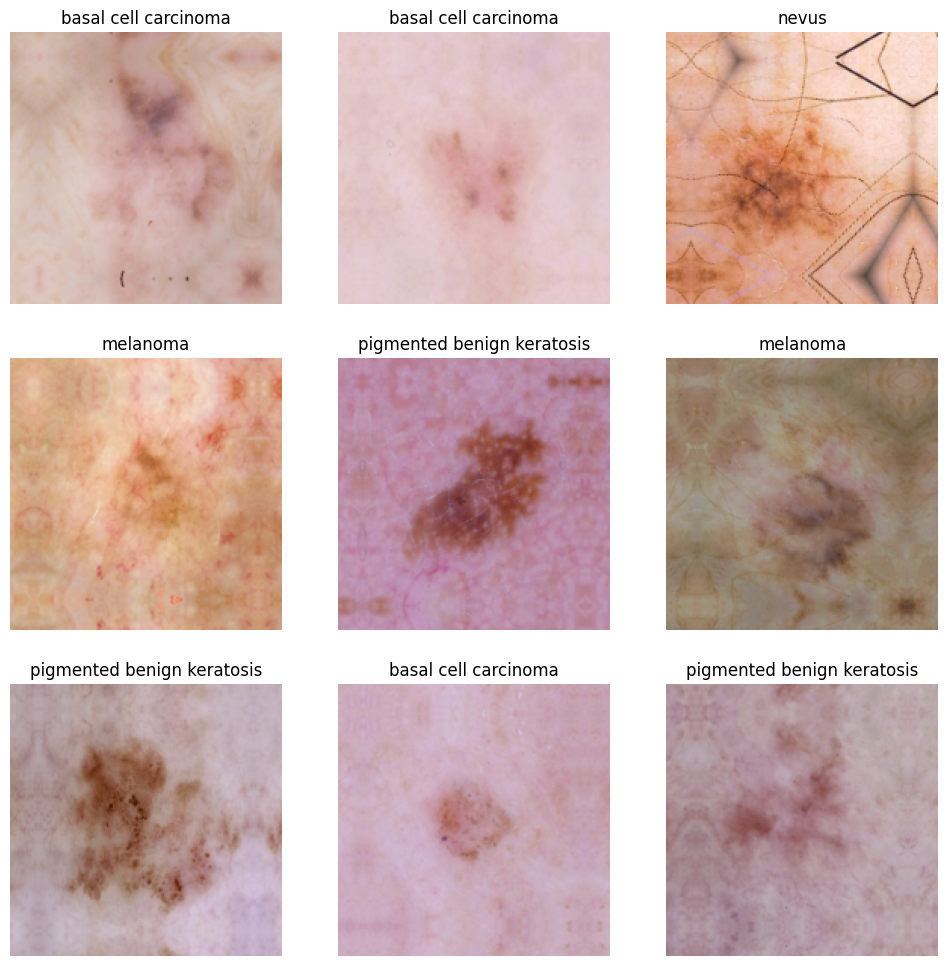

In [25]:
# visualise the operation of augmentation approach for a single training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Model Creation, compilation and training the model

In [26]:
## WE can use Dropout layer if there is an evidence of overfitting in your findings

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

Compiling the model

In [27]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the model

In [28]:
## Your code goes here, note: train your model for 100 epochs
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 8s 97ms/step - loss: 1.9793 - accuracy: 0.2472 - val_loss: 1.8319 - val_accuracy: 0.3043
Epoch 2/30
56/56 [==============================] - 5s 92ms/step - loss: 1.7952 - accuracy: 0.3410 - val_loss: 1.6787 - val_accuracy: 0.4049
Epoch 3/30
56/56 [==============================] - 5s 94ms/step - loss: 1.6514 - accuracy: 0.3979 - val_loss: 1.8079 - val_accuracy: 0.3199
Epoch 4/30
56/56 [==============================] - 5s 92ms/step - loss: 1.5804 - accuracy: 0.4302 - val_loss: 1.6055 - val_accuracy: 0.4430
Epoch 5/30
56/56 [==============================] - 5s 92ms/step - loss: 1.5829 - accuracy: 0.4470 - val_loss: 1.5261 - val_accuracy: 0.4519
Epoch 6/30
56/56 [==============================] - 5s 92ms/step - loss: 1.5291 - accuracy: 0.4576 - val_loss: 1.5287 - val_accuracy: 0.4564
Epoch 7/30
56/56 [==============================] - 5s 94ms/step - loss: 1.4705 - accuracy: 0.4648 - val_loss: 1.4642 - val_accuracy: 0.4966
Epoch 8/30
56

Visualizing the results

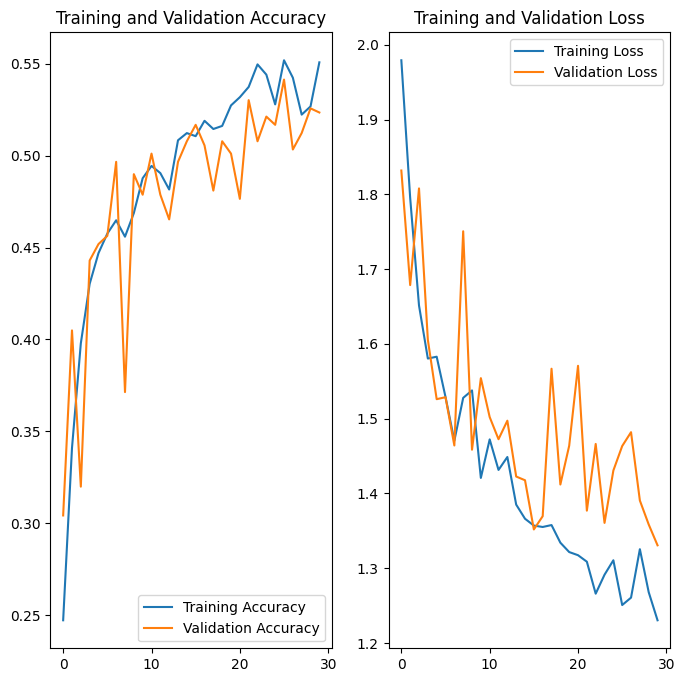

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings:\
We don't notice much increases in accuracy from the initial model, but we can clearly see the overfitting problem disappearing as a result of the addition of more data. But once more, drawing generalisations from just 20 epochs won't be accurate.

Determining the training dataset's class distribution

In [30]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,vascular lesion
2235,/content/Skin cancer ISIC The International Sk...,vascular lesion
2236,/content/Skin cancer ISIC The International Sk...,vascular lesion
2237,/content/Skin cancer ISIC The International Sk...,vascular lesion


In [31]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,vascular lesion
2235,/content/Skin cancer ISIC The International Sk...,vascular lesion
2236,/content/Skin cancer ISIC The International Sk...,vascular lesion
2237,/content/Skin cancer ISIC The International Sk...,vascular lesion


<BarContainer object of 9 artists>

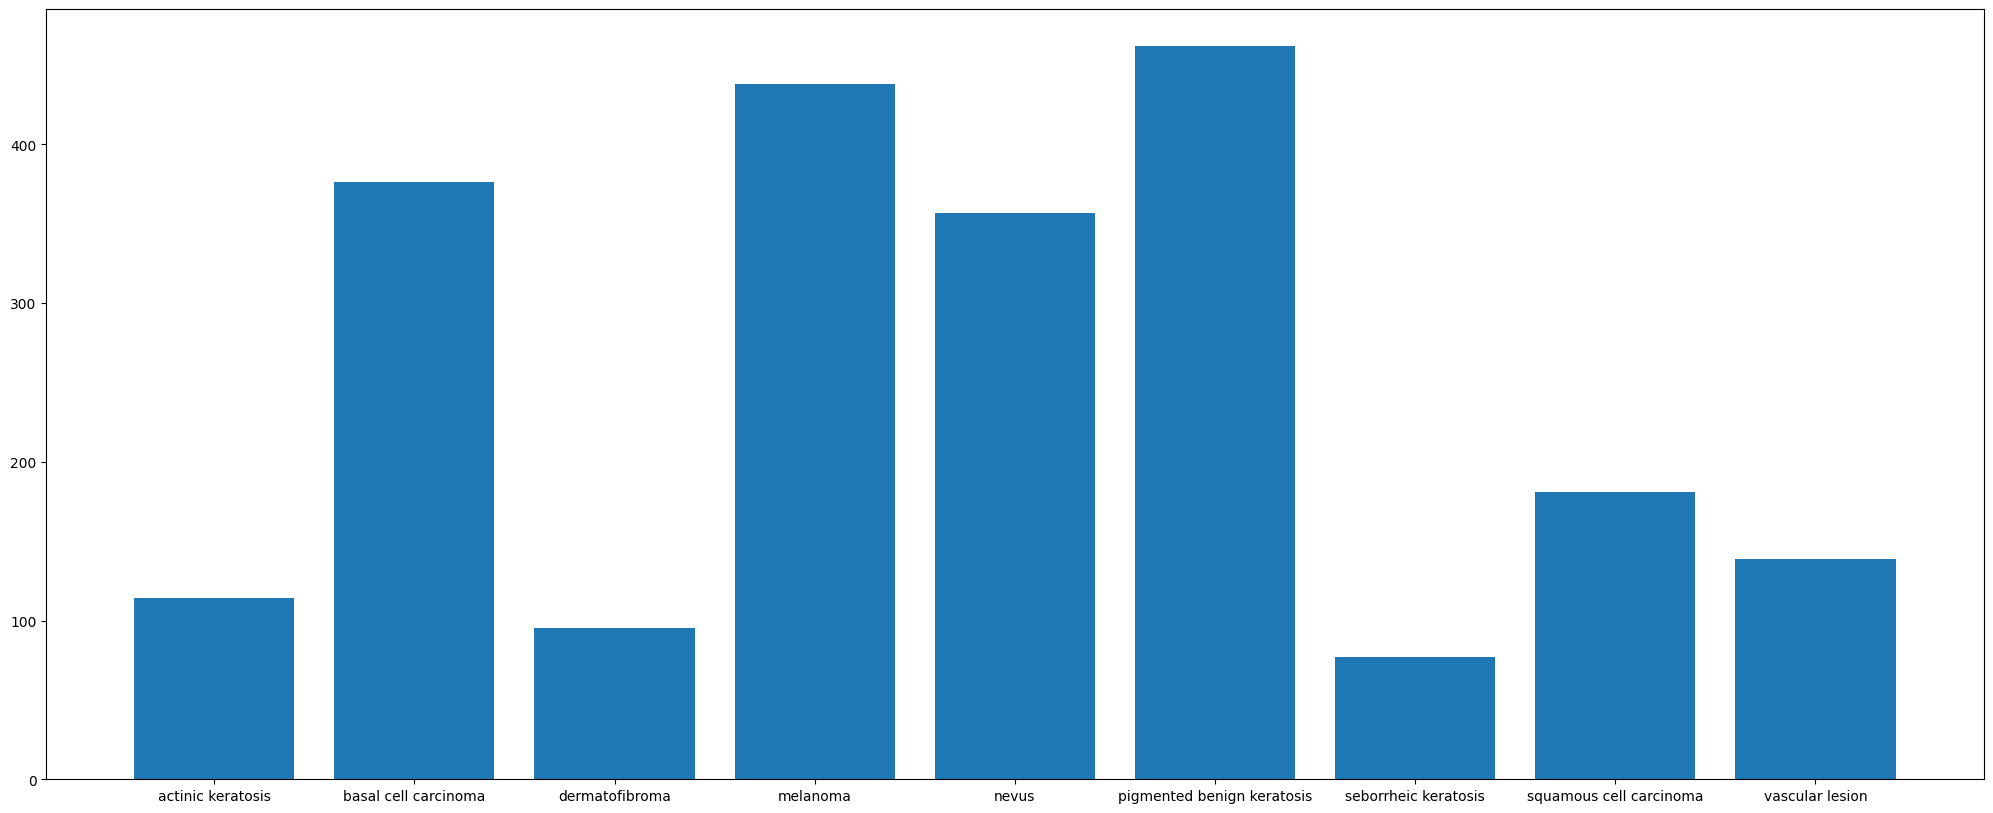

In [32]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

Findings
- Seborrheic keratosis is revealing the minimum distribution
- Pigmented Benign keratosis is revealing the maximum distribution of data
-Melanoma also contributing more as 2nd in distribution compare to others
Visualize the model results

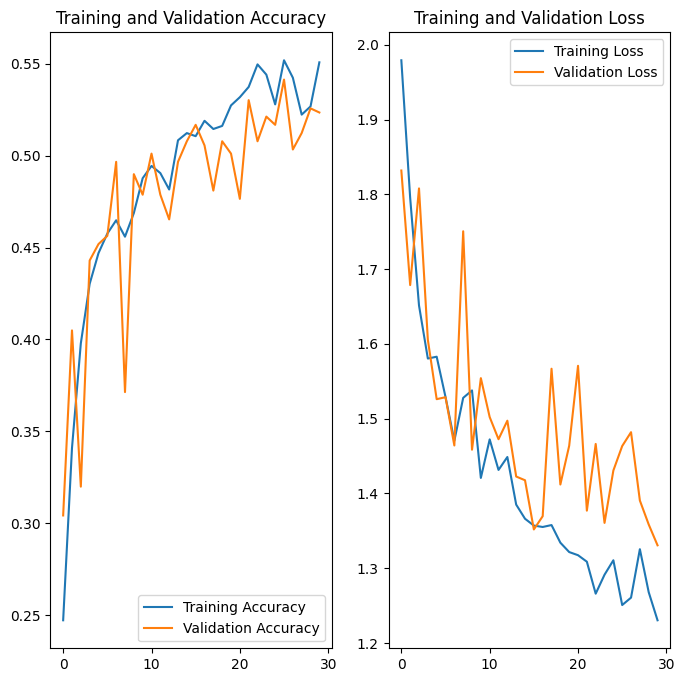

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

based on graph evaluation, you can observe that training and testing acuracy line following same trends and deviation is less.